### 
As of 9.6.2020

In [1]:
import os, sys
import copy as copyroot
import pandas as pd
from IPython.display import display
from matplotlib import pyplot as plt

from fastai2.basics import *
from fastai2.vision.all import *

from sklearn.preprocessing import StandardScaler

%load_ext autoreload
%autoreload 2

from module.mnist_helpers import build_df, eda_fig_1
from module.mnist_helpers import img_pt_plot, train_history_dualplot

In [2]:
path = untar_data(URLs.MNIST_TINY)
df = build_df(path)
df.head(2)

,fn,digit_class,scalar_top,scalar_bottom,scalar_pxsum,point_topleft_x,point_topleft_y,point_center_x,point_center_y
0,/train/3/7.png,3,5,25,35867,11,5,15,14
1,/train/3/7030.png,3,4,24,29717,9,4,14,13


In [3]:
y_names = [
    'point_topleft_x', 
    'point_topleft_y',
    'point_center_x',
    'point_center_y'
    ]

db =   DataBlock(blocks=(ImageBlock(cls=PILImageBW), 
                         PointBlock), 
                splitter=RandomSplitter(seed=0),
                get_x=ColReader('fn', pref=path),
                )

db_1_topleft = copyroot.deepcopy(db)
db_1_center  = copyroot.deepcopy(db)
db_2         = copyroot.deepcopy(db)

def set_get_y(db, cr):
    db.get_y = cr
    db.getters[db.n_inp:] = L(db.get_y)

set_get_y( db_1_topleft, ColReader(y_names[:2]) )
set_get_y( db_1_center,  ColReader(y_names[2:]) )
set_get_y( db_2,         ColReader(y_names) )

dl_1_topleft = db_1_topleft.dataloaders(df)
dl_1_center  = db_1_center.dataloaders(df)
dl_2         = db_2.dataloaders(df)


    Display items with corresponding Y's:
    Scalar targets are printed above the items
    Point targets are shown on image: (Red: topleft, Green: center)
    


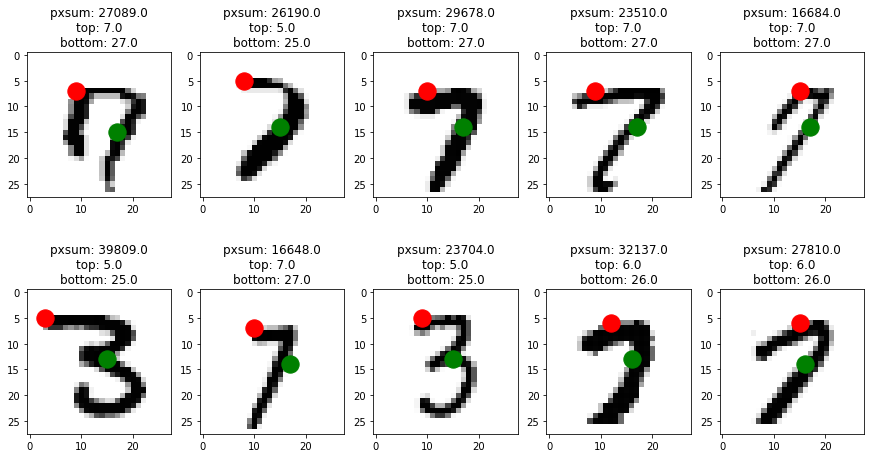

In [4]:
eda_fig_1(df, path)

In [7]:
y_p2 = torch.cat([_y for _x, _y in dl_2.train])
ys   = [y_p2[:,0], y_p2[:,1]]

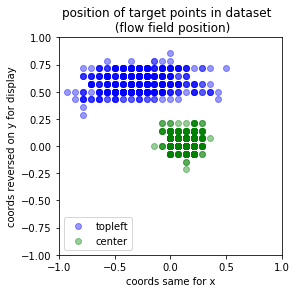

In [8]:
img_pt_plot(ys=ys,
           legend= ('topleft',  'center'))

### Fit Model - topleft
Uee 90 epochs to get a worthwhile model; only after ~30 epochs are we below baseline error

In [9]:
b_new_fit = False

history_fn = 'assets/pt3_topleft_3.csv'
model_fn   = 'pt3_topleft_2'

learn = cnn_learner(dl_1_topleft, 
                    resnet18, 
                    pretrained=True, 
                    metrics=[mae, R2Score()],
                    cbs=CSVLogger(history_fn),
                    y_range=(-1.,1.),
                   )
if b_new_fit:
    set_seed(17)
    with learn.no_logging():
        learn.fine_tune(90)
    learn.save(model_fn)
    
if not(b_new_fit):
    learn.load(model_fn)

In [10]:
train_history = pd.read_csv(history_fn)
display(train_history.head(2))
display(train_history.tail(2))

,epoch,train_loss,valid_loss,mae,r2_score,time
0,0,0.543690,0.092954,0.242163,-0.824727,00:09
1,1,0.532134,0.140789,0.303375,-1.763755,00:09


,epoch,train_loss,valid_loss,mae,r2_score,time
88,88,0.020841,0.021383,0.095315,0.580248,00:08
89,89,0.021200,0.021076,0.094615,0.586274,00:08


In [13]:
y_train = torch.cat([_y for _x,_y in dl_1_topleft.train])
y_valid = torch.cat([_y for _x,_y in dl_1_topleft.valid])

mean_y = y_train.view(-1,2).mean(dim=0)
mean_y

baseline_err = mse(torch.ones_like(y_valid) * mean_y, y_valid) 
baseline_err

tensor([-0.2881, -0.5898])

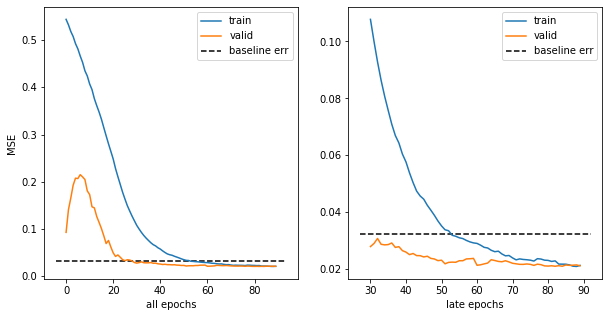

In [15]:
train_history_dualplot(train_history, 
                       fig2_startx=30, 
                       baseline_err=baseline_err,
                      )

### New Initiative

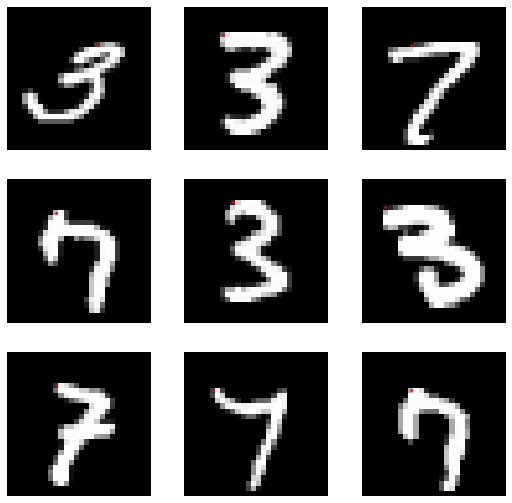

In [17]:
dl_1_topleft.show_batch()

In [19]:
b = dl_1_topleft.one_batch()

In [22]:
b[1].shape

torch.Size([64, 1, 2])

In [23]:
b[0].shape

torch.Size([64, 3, 28, 28])

In [24]:
y_names = [
    'point_topleft_x', 
    'point_topleft_y',
    'point_center_x',
    'point_center_y'
    ]

db_new =   DataBlock(blocks=(ImageBlock(cls=PILImageBW), 
                         PointBlock), 
                splitter=RandomSplitter(seed=0),
                get_x=ColReader('fn', pref=path),
                get_y=ColReader(y_names[:2]),
                item_tfms=Resize(128,128),
                )

dl_new_topleft = db_new.dataloaders(df)

In [25]:
b_new = dl_new_topleft.one_batch()

In [26]:
b_new[0].shape

torch.Size([64, 1, 128, 128])

In [29]:
dl_new_topleft.tfms[1]

Pipeline: ColReader -> TensorPoint.create

### Fit the two dls: `dl_1_topleft` vs `dl_new_topleft`

In [74]:
learn_orig = cnn_learner(
                    dl_1_topleft, 
                    resnet18, 
                    pretrained=True, 
                    metrics=[mae, R2Score()],
                    #cbs=CSVLogger(history_fn),
                    y_range=(-1.,1.),
#                     y_range=(-.5,.5),
                   )

learn_new  = cnn_learner(
                    dl_new_topleft, 
                    resnet18, 
                    pretrained=True, 
                    metrics=[mae, R2Score()],
#                     cbs=CSVLogger(history_fn),
                    y_range=(-1.,1.),
#                     y_range=(-.5,.5),
                   )

In [75]:
learn_orig.fine_tune(10)

epoch,train_loss,valid_loss,mae,r2_score,time
0,0.600177,0.097594,0.257748,-0.915817,00:05


epoch,train_loss,valid_loss,mae,r2_score,time
0,0.536301,0.086216,0.227488,-0.692468,00:09
1,0.515946,0.132650,0.290435,-1.603988,00:09
2,0.504776,0.144977,0.274275,-1.845967,00:09
3,0.485707,0.206619,0.348814,-3.056040,00:09
4,0.461724,0.202109,0.343524,-2.967511,00:09
5,0.434426,0.165391,0.307140,-2.246705,00:09
6,0.405776,0.148945,0.287065,-1.923870,00:09
7,0.385483,0.135889,0.268694,-1.667579,00:09
8,0.365544,0.124611,0.255976,-1.446180,00:09
9,0.350018,0.118367,0.249564,-1.323605,00:09


In [76]:
learn_new.fine_tune(10)

epoch,train_loss,valid_loss,mae,r2_score,time
0,0.595006,0.485561,0.588073,-8.531814,00:23


Exception ignored in: <function _releaseLock at 0x7fc2adbf63b0>
Traceback (most recent call last):
  File "/home/user/anaconda3/envs/fastai2/lib/python3.7/logging/__init__.py", line 221, in _releaseLock
    def _releaseLock():
KeyboardInterrupt


RuntimeError: DataLoader worker (pid(s) 2212, 2213) exited unexpectedly

In [35]:
learn_new.model

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  

In [36]:
learn_orig.model[1]()

Sequential(
  (0): AdaptiveConcatPool2d(
    (ap): AdaptiveAvgPool2d(output_size=1)
    (mp): AdaptiveMaxPool2d(output_size=1)
  )
  (1): Flatten(full=False)
  (2): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (3): Dropout(p=0.25, inplace=False)
  (4): Linear(in_features=1024, out_features=512, bias=False)
  (5): ReLU(inplace=True)
  (6): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (7): Dropout(p=0.5, inplace=False)
  (8): Linear(in_features=512, out_features=2, bias=False)
  (9): SigmoidRange(low=-0.5, high=0.5)
)

### Here's a problem, my `y_range` is wrong
Actually it was correct in other notebooks just copied in wrong.

In [48]:
b = dl_1_topleft.one_batch()

In [57]:
b[1][:,0,0].min(), b[1][:,0,0].max()

(tensor(-0.9286), tensor(0.2857))

In [58]:
b[1][:,0,1].min(), b[1][:,0,1].max()

(tensor(-0.8571), tensor(-0.4286))

In [61]:
preds = learn_new.get_preds()

In [63]:
len(preds)

2

In [72]:
pred_x, pred_y = preds[0][:,0], preds[0][:,1]

print(
    pred_x.min(), pred_x.max(), '\n', 
    pred_y.min(), pred_y.max())

tensor(-0.4960) tensor(0.5000) 
 tensor(-0.4936) tensor(0.5000)


### Custom Arch

In [41]:
y_names = [
    'point_topleft_x', 
    'point_topleft_y',
    ]

db_1c = DataBlock(blocks=(ImageBlock(cls=PILImageBW), PointBlock), 
                  splitter=RandomSplitter(),
                   get_x=ColReader('fn', pref=path),
                   get_y=ColReader(y_names),
                  )

dls = db_1c.dataloaders(df)

x, y = dls.one_batch()

x.shape

torch.Size([64, 1, 28, 28])

In [42]:
net3 = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=784, out_features=28),
            nn.Linear(in_features=28, out_features=2, bias=False),
            SigmoidRange(-1., 1),
            )


In [46]:
learn_net3 = Learner(dls, net3, loss_func=MSELossFlat(), )

##### Is `.fit()` or `fine_tune()` superior?

In [47]:
learn_net3.fit(10)

epoch,train_loss,valid_loss,time
0,0.015516,0.021542,00:02
1,0.015250,0.019115,00:02
2,0.014526,0.018657,00:02
3,0.013890,0.018851,00:02
4,0.013402,0.018523,00:02
5,0.012840,0.018237,00:02
6,0.012484,0.018506,00:02
7,0.012122,0.018630,00:02
8,0.011756,0.018682,00:02
9,0.011421,0.019027,00:02


In [44]:
learn_net3.fine_tune(10)

epoch,train_loss,valid_loss,time
0,0.166153,0.043112,00:02


epoch,train_loss,valid_loss,time
0,0.037250,0.033117,00:02
1,0.032913,0.027805,00:02
2,0.029817,0.023444,00:02
3,0.026772,0.022481,00:02
4,0.024902,0.021360,00:02
5,0.023297,0.020594,00:02
6,0.021748,0.019941,00:02
7,0.020507,0.019763,00:02
8,0.019526,0.019609,00:02
9,0.018687,0.019596,00:02


##### Check y_range on learn_net3
Looks good

In [73]:
preds = learn_net3.get_preds()

pred_x, pred_y = preds[0][:,0], preds[0][:,1]

print(
    pred_x.min(), pred_x.max(), '\n', 
    pred_y.min(), pred_y.max())

tensor(-0.7782) tensor(0.3794) 
 tensor(-0.8417) tensor(-0.2615)


### Try using the head of resnet18 to learn points tasks
First build a batch and look at the size

In [78]:
b = dl_1_topleft.one_batch()

In [79]:
b[0].shape

torch.Size([64, 3, 28, 28])

##### Grab the head and pass watch the dimension changes over each step

In [110]:
m = learn_orig.model[1]

In [111]:
tmp = b[0].clone()

for component in m:
    try:
        tmp = component(tmp)
        print(tmp.shape)
        print('-------------------')
    except Exception as e:
        print(f'err on component: {component}')
        print(e)

torch.Size([64, 6, 1, 1])
-------------------
torch.Size([64, 6])
-------------------
err on component: BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
running_mean should contain 6 elements not 1024
torch.Size([64, 6])
-------------------
err on component: Linear(in_features=1024, out_features=512, bias=False)
size mismatch, m1: [64 x 6], m2: [1024 x 512] at /opt/conda/conda-bld/pytorch_1579022030672/work/aten/src/TH/generic/THTensorMath.cpp:136
torch.Size([64, 6])
-------------------
err on component: BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
running_mean should contain 6 elements not 512
torch.Size([64, 6])
-------------------
err on component: Linear(in_features=512, out_features=2, bias=False)
size mismatch, m1: [64 x 6], m2: [512 x 2] at /opt/conda/conda-bld/pytorch_1579022030672/work/aten/src/TH/generic/THTensorMath.cpp:136
torch.Size([64, 6])
-------------------


In [105]:
out = m[:1](b[0])
out.shape

torch.Size([64, 6, 1, 1])

In [109]:
out = m[:2](b[0])
out.shape

torch.Size([64, 6])

In [116]:
m[0]

AdaptiveConcatPool2d(
  (ap): AdaptiveAvgPool2d(output_size=1)
  (mp): AdaptiveMaxPool2d(output_size=1)
)

##### Clearly we can't do prediction on these features, the head is a failure

In [117]:
out

tensor([[ 2.2489,  2.4286,  2.6400, -1.4603, -1.3635, -1.1352],
        [ 2.2489,  2.4286,  2.6400, -1.8088, -1.7197, -1.4899],
        [ 2.2489,  2.4286,  2.6400, -1.4192, -1.3214, -1.0933],
        [ 2.2318,  2.4111,  2.6226, -1.3671, -1.2682, -1.0403],
        [ 2.2489,  2.4286,  2.6400, -1.5942, -1.5003, -1.2715],
        [ 2.2489,  2.4286,  2.6400, -1.6414, -1.5486, -1.3195],
        [ 2.2489,  2.4286,  2.6400, -1.5189, -1.4233, -1.1948],
        [ 2.2489,  2.4286,  2.6400, -1.7210, -1.6299, -1.4005],
        [ 2.2489,  2.4286,  2.6400, -1.6556, -1.5631, -1.3339],
        [ 2.2489,  2.4286,  2.6400, -1.7244, -1.6334, -1.4039],
        [ 2.2489,  2.4286,  2.6400, -1.5589, -1.4642, -1.2355],
        [ 2.2489,  2.4286,  2.6400, -1.5170, -1.4214, -1.1929],
        [ 2.2489,  2.4286,  2.6400, -1.5589, -1.4643, -1.2356],
        [ 2.2489,  2.4286,  2.6400, -1.2519, -1.1504, -0.9231],
        [ 2.2489,  2.4286,  2.6400, -1.5789, -1.4847, -1.2559],
        [ 2.2489,  2.4286,  2.6400, -1.6